# Multi-Input Models Learning
## A multi-model deep learning approach for image recognition


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, shutil
import cv2
from os import listdir
from os.path import isfile, join
import string
import re
import nltk
from keras import layers
from keras import Input
from keras.models import Model
from keras import models

%matplotlib inline

Using TensorFlow backend.


In [2]:
original_dataset_dir = '/Users/yuhuang/yuefeng/machine-learning/deep_learning/multi_task_learning/data/ESPGame100k'
base_dataset_dir = '/Users/yuhuang/yuefeng/machine-learning/deep_learning/multi_task_learning/data/ESPGame100k_small'

In [3]:
original_label_path = original_dataset_dir + '/labels'
original_label_files = [f for f in listdir(original_label_path) if isfile(join(original_label_path, f))]

In [4]:
original_label_files[:2]

['e16c6ef2cc57d8ec07616478e2bbb3bc641ca81096108552909f0789a538fdfe.jpg.desc',
 '69a84c8f2178082a01c28d3588e6f3382006952eb370a3cbe069a86c4ade14c3.jpg.desc']

In [5]:
original_image_path = original_dataset_dir + '/thumbnails'
original_image_files = [f for f in listdir(original_image_path) if isfile(join(original_image_path, f))]

In [6]:
original_image_files[:2]

['a4cb5b648b45c7dea221a91ce4895eebb74b4281ab52b43a7f20f343ba5fad9e.jpg',
 'b1588607c26f0e8c990b590873c42d0a678ace0d97c4704c02a75c048a05b44d.jpg']

In [8]:
print('number of images: {}, number of tags: {}'.format(len(original_image_files), len(original_label_files)))

number of images: 100000, number of tags: 100000


In [11]:
original_image_files = np.array(original_image_files)
original_label_files = np.array(original_label_files)

In [12]:
dataset_size = original_label_files.shape[0]
perm = np.arange(dataset_size)
np.random.shuffle(perm)
original_image_files = original_image_files[perm]
original_label_files = original_label_files[perm]

### setup a small dataset

In [13]:
if not os.path.isdir(base_dataset_dir):
    os.mkdir(base_dataset_dir)
    
small_label_path = os.path.join(base_dataset_dir, 'labels')
small_image_path = os.path.join(base_dataset_dir, 'thumbnails')
if not os.path.isdir(small_label_path):
    os.mkdir(small_label_path)
if not os.path.isdir(small_image_path):
    os.mkdir(small_image_path)

In [14]:
# copy label files
for fname in original_label_files[:2000]:
    src = os.path.join(original_label_path, fname)
    dst = os.path.join(small_label_path, fname)
    shutil.copyfile(src, dst)

In [15]:
# copy image files
for fname in original_label_files[:2000]:
    img_fname = fname[:-5]
    src = os.path.join(original_image_path, img_fname)
    dst = os.path.join(small_image_path, img_fname)
    shutil.copyfile(src, dst)

In [16]:
label_map = {'label_file' : [], 'word_tags' : []}
for fname in listdir(small_label_path): 
    f = join(small_label_path, fname)
    if isfile(f):
        f = open(f)
        label_map['label_file'].append(fname)
        line = f.read().splitlines()
        label_map['word_tags'].append(line)
label_df = pd.DataFrame(label_map)
label_df.head()

,label_file,word_tags
0,3a2b416aa30bb19caea88273cd0718d75b6c3ec23e2d02...,"[river, trees, forest, pond, goose, water, swa..."
1,356e2ac35c7bc2a2a6e0c8a83306f8777889eb7d9fb237...,"[gray, wheels, grey, sky, fast, black, silver,..."
2,1001340000000000000000000000000000000000000000...,"[hat, mountains, girl, woman, man, sky, water,..."
3,e9b91b846d9ce1a6741afaeaa1ce507309142b43d0babb...,"[fit, exercise, sunglasses, shirt, jogger, gla..."
4,9c87bfb32a4ed7e76049a43a73d6abad39144e70cd1feb...,"[orange, woman, man, no, in, people, love, min..."


In [17]:
class Preprocessing(object):
    def __init__(self, data, source_column_name='word_tags', target_column_name='word_tags_clean'):
        self.data = data
        self.source_column_name = source_column_name
        self.feature_name = target_column_name
        
    def remove_punctuation(self, text):
        text_nopunct = "".join([char for char in text if char not in string.punctuation])# It will discard all punctuations
        return text_nopunct
    
    def tokenize(self, text):
        # Match one or more characters which are not word character
        tokens = re.split('\W+', text) 
        return tokens
    
    def remove_stopwords(self, tokenized_list):
        # Remove all English Stopwords
        stopword = nltk.corpus.stopwords.words('english')
        text = [word for word in tokenized_list if word not in stopword]
        return text
    
    def stemming(self, tokenized_text):
        ps = nltk.PorterStemmer()
        text = [ps.stem(word) for word in tokenized_text]
        return text
    
    def lemmatizing(self, tokenized_text):
        wn = nltk.WordNetLemmatizer()
        text = [wn.lemmatize(word) for word in tokenized_text]
        return text
    
    def alnum(self, text):
        def hasNumbers(inputString):
            return any(char.isdigit() for char in inputString)
        
        text = [word for word in text if len(word) > 0 and word.isalnum() and not word.isdigit() and not hasNumbers(word)]
        return text
    
    def tokens_to_string(self, tokens_string):
        try:
            list_obj = ast.literal_eval(tokens_string)
            text = " ".join(list_obj)
        except:
            text = None
        return text
    
    def dropna(self):
        feature_name = self.feature_name
        if self.data[feature_name].isnull().sum() > 0:
            column_list=[feature_name]
            self.data = self.data.dropna(subset=column_list)
            return self.data
        
    def preprocessing(self):
        nopunc = self.source_column_name + '_nopunc'
        tokenized = self.source_column_name + '_tokenized'
        nostop = self.source_column_name + '_nostop'
        stemmed = self.source_column_name + '_stemmed'
        lemmatized = self.source_column_name + '_lemmatized'
        # self.data[nopunc] = self.data[self.source_column_name].apply(lambda x: self.remove_punctuation(x))
        # self.data[tokenized] = self.data[nopunc].apply(lambda x: self.tokenize(x.lower())) 
        self.data[nostop] = self.data[self.source_column_name].apply(lambda x: self.remove_stopwords(x))
        self.data[self.feature_name] = self.data[nostop].apply(lambda x: self.alnum(x))
        # self.data[nostop] = self.data[tokenized].apply(lambda x: self.remove_stopwords(x))
        # self.data[stemmed] = self.data[nostop].apply(lambda x: self.stemming(x))
        # self.data[lemmatized] = self.data[nostop].apply(lambda x: self.lemmatizing(x))
        
        # save cleaned dataset into csv file and load back
        # self.save()
        # self.load()
        
        # self.data[self.feature_name] = self.data[lemmatized].apply(lambda x: self.tokens_to_string(x))
        
        
        # self.dropna()
        
        # drop_columns = [nopunc, tokenized, nostop, stemmed, lemmatized] 
        # self.data.drop(drop_columns, axis=1, inplace=True)
        
        return self.data
    
    def save(self, filepath="./data/tags_cleaned.csv"):
        self.data.to_csv(filepath, index=False, sep=',')  
        
    def load(self, filepath="./data/tags_cleaned.csv"):
        self.data = pd.read_csv(filepath)
        return self.data

In [18]:
pp = Preprocessing(label_df.copy(), source_column_name='word_tags', target_column_name='word_tags_clean')
label_df_clean = pp.preprocessing()

In [19]:
label_df_clean.head()

,label_file,word_tags,word_tags_nostop,word_tags_clean
0,3a2b416aa30bb19caea88273cd0718d75b6c3ec23e2d02...,"[river, trees, forest, pond, goose, water, swa...","[river, trees, forest, pond, goose, water, swa...","[river, trees, forest, pond, goose, water, swa..."
1,356e2ac35c7bc2a2a6e0c8a83306f8777889eb7d9fb237...,"[gray, wheels, grey, sky, fast, black, silver,...","[gray, wheels, grey, sky, fast, black, silver,...","[gray, wheels, grey, sky, fast, black, silver,..."
2,1001340000000000000000000000000000000000000000...,"[hat, mountains, girl, woman, man, sky, water,...","[hat, mountains, girl, woman, man, sky, water,...","[hat, mountains, girl, woman, man, sky, water,..."
3,e9b91b846d9ce1a6741afaeaa1ce507309142b43d0babb...,"[fit, exercise, sunglasses, shirt, jogger, gla...","[fit, exercise, sunglasses, shirt, jogger, gla...","[fit, exercise, sunglasses, shirt, jogger, gla..."
4,9c87bfb32a4ed7e76049a43a73d6abad39144e70cd1feb...,"[orange, woman, man, no, in, people, love, min...","[orange, woman, man, people, love, minutes, me...","[orange, woman, man, people, love, minutes, me..."


In [20]:
non_empty_tags = label_df_clean['word_tags_clean'].apply(lambda x: len(x) > 0)
label_df_clean = label_df_clean[non_empty_tags]

In [21]:
label_df_clean.head()

,label_file,word_tags,word_tags_nostop,word_tags_clean
0,3a2b416aa30bb19caea88273cd0718d75b6c3ec23e2d02...,"[river, trees, forest, pond, goose, water, swa...","[river, trees, forest, pond, goose, water, swa...","[river, trees, forest, pond, goose, water, swa..."
1,356e2ac35c7bc2a2a6e0c8a83306f8777889eb7d9fb237...,"[gray, wheels, grey, sky, fast, black, silver,...","[gray, wheels, grey, sky, fast, black, silver,...","[gray, wheels, grey, sky, fast, black, silver,..."
2,1001340000000000000000000000000000000000000000...,"[hat, mountains, girl, woman, man, sky, water,...","[hat, mountains, girl, woman, man, sky, water,...","[hat, mountains, girl, woman, man, sky, water,..."
3,e9b91b846d9ce1a6741afaeaa1ce507309142b43d0babb...,"[fit, exercise, sunglasses, shirt, jogger, gla...","[fit, exercise, sunglasses, shirt, jogger, gla...","[fit, exercise, sunglasses, shirt, jogger, gla..."
4,9c87bfb32a4ed7e76049a43a73d6abad39144e70cd1feb...,"[orange, woman, man, no, in, people, love, min...","[orange, woman, man, people, love, minutes, me...","[orange, woman, man, people, love, minutes, me..."


In [22]:
label_df_clean.shape

(2000, 4)

In [23]:
num_of_samples = label_df_clean.shape[0]
num_of_samples

2000

## GloVe
* glove.6B.zip: https://nlp.stanford.edu/projects/glove/

In [24]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

maxlen = 100
training_samples = num_of_samples
tag_vocabulary_size = 10000
max_words = tag_vocabulary_size

In [25]:
glove_dir = '/Users/yuhuang/yuefeng/machine-learning/deep_learning/multi_task_learning/data/'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [26]:
tokenizer = Tokenizer(num_words=max_words)
texts = []
for tag_list in label_df_clean['word_tags']:
    texts.append(' '.join(tag_list))
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Found {} unique tokens'.format(len(word_index)))
tag_data = pad_sequences(sequences, maxlen=maxlen)

Found 4267 unique tokens


In [38]:
tag_data.shape

(2000, 100)

In [27]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

In [28]:
tag_data.shape

(2000, 100)

In [29]:
tag_input = Input(shape=(None,), dtype='int32', name='tag')
embedded_tag = layers.Embedding(max_words, embedding_dim)(tag_input)
encoded_tag = layers.LSTM(512)(embedded_tag)

## Conv2D

In [30]:
from keras.applications import VGG16
# see: https://towardsdatascience.com/step-by-step-guide-to-using-pretrained-models-in-keras-c9097b647b29
image_input = Input(shape=(150, 150, 3), name='image')
vgg16 = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))(image_input)
x = layers.Flatten()(vgg16) 
x = layers.Dense(256, activation='relu')(x)

In [31]:
concatenated = layers.concatenate([x, encoded_tag], axis=-1)
output = layers.Dense(1, activation='sigmoid')(concatenated)

model = Model([image_input, tag_input], output)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [32]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
vgg16 (Model)                   (None, 4, 4, 512)    14714688    image[0][0]                      
__________________________________________________________________________________________________
tag (InputLayer)                (None, None)         0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 8192)         0           vgg16[1][0]                      
____________________________________________________________________________________________

In [33]:
model.layers[4].set_weights([embedding_matrix])
model.layers[4].trainable = False

In [34]:
dim = (150, 150)
X_image_train = []
X_tag_train = tag_data
y_train = []
    
for fname in listdir(small_image_path):
    fpath = os.path.join(small_image_path, fname)
    im = cv2.imread(fpath)
    im_resized = cv2.resize(im, dim, interpolation = cv2.INTER_AREA)
    X_image_train.append(im_resized)
    y_train.append(1)
    
# add wrong tag samples
num_negative_samples = len(y_train)
for i in range(num_negative_samples):
    image = X_image_train[i]
    X_image_train.append(image)
    j = (i + 1) % num_negative_samples # get a different tag
    tag = X_tag_train[j]
    X_tag_train = np.append(X_tag_train, tag) 
    y_train.append(0)

In [35]:
X_image_train = np.array(X_image_train)
X_tag_train   = np.array(X_tag_train)
y_train       = np.array(y_train)

In [36]:
perm = np.arange(y_train.shape[0])
np.random.shuffle(perm)
X_image_train = X_image_train[perm]
X_tag_train   = X_tag_train[perm]
y_train       = y_train[perm]

In [37]:
X_image_train.shape, X_tag_train.shape, y_train.shape

((4000, 150, 150, 3), (4000,), (4000,))

In [39]:
model.fit([X_image_train, X_tag_train], y_train, epochs=30, batch_size=64)

/Users/yuhuang/anaconda3/envs/deeplearning/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/Users/yuhuang/anaconda3/envs/deeplearning/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
4000/4000 [==============================] - 674s 168ms/step - loss: 3029.1306 - acc: 0.4990
Epoch 2/30
4000/4000 [==============================] - 685s 171ms/step - loss: 1.3183 - acc: 0.5203
Epoch 3/30
4000/4000 [==============================] - 677s 169ms/step - loss: 0.8122 - acc: 0.5150
Epoch 4/30
4000/4000 [==============================] - 684s 171ms/step - loss: 0.7910 - acc: 0.5345
Epoch 5/30
4000/4000 [==============================] - 669s 167ms/step - loss: 0.7288 - acc: 0.5362
Epoch 6/30
4000/4000 [==============================] - 673s 168ms/step - loss: 0.7430 - acc: 0.5318
Epoch 7/30
4000/4000 [==============================] - 676s 169ms/step - loss: 0.6705 - acc: 0.5330
Epoch 8/30
4000/4000 [==============================] - 668s 167ms/step - loss: 0.9406 - acc: 0.5385
Epoch 9/30
4000/4000 [==============================] - 670s 168ms/step - loss: 0.7593 - acc: 0.5360
Epoch 10/30
4000/4000 [==============================] - 678s 170ms/step - loss: 0.6902 

In [ ]:
# model.save('multi-input-models-epoch5.h5')

In [40]:
from keras.models import model_from_json

# serialize model to JSON
model_json = model.to_json()
with open("multi-input-models-epoch-30.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("multi-input-models-epoch-30.h5")
print("Saved model to disk")
 
# load json and create model
json_file = open('multi-input-models-epoch-30.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("multi-input-models-epoch-30.h5")
print("Loaded model from disk")

Saved model to disk
Loaded model from disk


## Testing

In [41]:
test_image_dir = '/Users/yuhuang/yuefeng/machine-learning/deep_learning/multi_task_learning/data/private_test_images'
test_label_dir = '/Users/yuhuang/yuefeng/machine-learning/deep_learning/multi_task_learning/data/private_test_options'

In [42]:
test_image_label_map = {'image_file' : [], 'label_file_1' : [], 'word_tags_1' : [], 'label_file_2' : [], 'word_tags_2' : []}
for fname in listdir(test_image_dir): 
    test_image_label_map['image_file'].append(fname)
    lfname_base = fname[:-4]
    lfname1 = lfname_base + '.option_0.desc'
    lfname2 = lfname_base + '.option_1.desc'
    lf1 = join(test_label_dir, lfname1)
    lf2 = join(test_label_dir, lfname2)
    if isfile(lf1):
        f1 = open(lf1)
        test_image_label_map['label_file_1'].append(lfname1)
        line = f1.read().splitlines()
        test_image_label_map['word_tags_1'].append(line)
        f1.close()
    else:
        print('invalid file: ' + lfname1)
        
    if isfile(lf2):
        f2 = open(lf2)
        test_image_label_map['label_file_2'].append(lfname2)
        line = f2.read().splitlines()
        test_image_label_map['word_tags_2'].append(line)
        f2.close()
    else:
        print('invalid file: ' + lfname2)
        
test_image_label_df = pd.DataFrame(test_image_label_map)
test_image_label_df.head()

,image_file,label_file_1,word_tags_1,label_file_2,word_tags_2
0,348.png,348.option_0.desc,"[airport, news, banner, jacket, flourescent, b...",348.option_1.desc,"[man, face, arm, hand, black, shirt, wall, sit..."
1,412.png,412.option_0.desc,"[man, sunglasses, grey, gray, black, white, tr...",412.option_1.desc,"[sketch, art, drawing, house, window, building..."
2,374.png,374.option_0.desc,"[cell, phones, phone, cellphone, cellphones, a...",374.option_1.desc,"[globe, spots, dots, planets, grid, space, bla..."
3,360.png,360.option_0.desc,"[blonde, girl, face, sun, telephone, pole, out...",360.option_1.desc,"[man, men, girl, hidden, face, glove, rebel, b..."
4,406.png,406.option_0.desc,"[woman, person, face, sunglasses, blue, sky, u...",406.option_1.desc,"[word, facepaint, painted, colorful, feathers,..."


image file name:  406.png


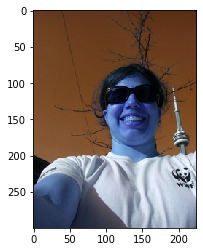

In [91]:
dim = (150, 150)
X_image_test = []

count = 0
for fname in listdir(test_image_dir):
    fpath = os.path.join(test_image_dir, fname)
    im = cv2.imread(fpath)
    
    if count == 4: # or count == 30:
        print('image file name: ', fname)
        plt.imshow(im)
    
    im_resized = cv2.resize(im, dim, interpolation = cv2.INTER_AREA)
    # print (type(im), im_resized.shape) # (150, 150, 3)
    X_image_test.append(im_resized)
    count += 1

In [44]:
tokenizer_test = Tokenizer(num_words=max_words)
texts_1 = []
texts_2 = []
texts_all = []
for tag_list in test_image_label_df['word_tags_1']:
    texts_1.append(' '.join(tag_list))
for tag_list in test_image_label_df['word_tags_2']:
    texts_2.append(' '.join(tag_list))
texts_all.extend(texts_1)
texts_all.extend(texts_2)  

type(texts_all)

list

In [45]:
tokenizer_test.fit_on_texts(texts_all)
sequences_1 = tokenizer_test.texts_to_sequences(texts_1)
sequences_2 = tokenizer_test.texts_to_sequences(texts_2)

word_index_test = tokenizer_test.word_index
print('Found {} unique tokens in test'.format(len(word_index_test)))
tag_data_test_1 = pad_sequences(sequences_1, maxlen=maxlen)
tag_data_test_2 = pad_sequences(sequences_2, maxlen=maxlen)

Found 1477 unique tokens in test


In [46]:
X_image_test = np.array(X_image_test)
X_tag_test_1 = np.array(tag_data_test_1)
X_tag_test_2 = np.array(tag_data_test_2)

In [47]:
X_image_test.shape, X_tag_test_1.shape, X_tag_test_2.shape

((500, 150, 150, 3), (500, 100), (500, 100))

In [48]:
y_predict_1 = loaded_model.predict([X_image_test, X_tag_test_1])
y_predict_2 = loaded_model.predict([X_image_test, X_tag_test_2])

In [49]:
y_predict_arr_1 = np.array(y_predict_1)
y_predict_arr_2 = np.array(y_predict_2)

In [50]:
y_predict_arr_1.shape, y_predict_arr_2.shape

((500, 1), (500, 1))

In [51]:
y_predict_1_0 = y_predict_arr_1[0]
y_predict_2_0 = y_predict_arr_2[0]

In [52]:
y_predict_1_0, y_predict_2_0

(array([0.06431153], dtype=float32), array([0.991642], dtype=float32))

In [53]:
word_tags_2 = test_image_label_df.iloc[0]['word_tags_2']
word_tags_2

['man', 'face', 'arm', 'hand', 'black', 'shirt', 'wall', 'sitting', 'knee']

In [54]:
word_tags_1 = test_image_label_df.iloc[0]['word_tags_1']
word_tags_1

['airport',
 'news',
 'banner',
 'jacket',
 'flourescent',
 'black',
 'man',
 'person',
 'face',
 'profile',
 'car',
 'cars',
 'street']

In [61]:
idx = 30 # 363.png

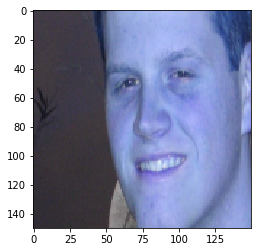

In [62]:
plt.imshow(X_image_test[idx])

In [63]:
y_predict_1_idx = y_predict_arr_1[idx]
y_predict_2_idx = y_predict_arr_2[idx]
y_predict_1_idx, y_predict_2_idx

(array([0.06917137], dtype=float32), array([0.8760386], dtype=float32))

In [64]:
word_tags_2 = test_image_label_df.iloc[idx]['word_tags_2']
word_tags_2

['word',
 'man',
 'person',
 'eyebrows',
 'eyes',
 'nose',
 'hair',
 'book',
 'red',
 'blue']

In [65]:
word_tags_1 = test_image_label_df.iloc[idx]['word_tags_1']
word_tags_1

['face', 'man', 'closeup', 'person', 'red', 'hair', 'grey', 'gray']

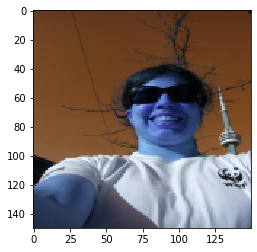

In [87]:
idx = 4 # idx 20 - 163.png
plt.imshow(X_image_test[idx])

In [88]:
y_predict_1_idx = y_predict_arr_1[idx]
y_predict_2_idx = y_predict_arr_2[idx]
y_predict_1_idx, y_predict_2_idx

(array([0.99750113], dtype=float32), array([0.5078792], dtype=float32))

In [89]:
word_tags_2 = test_image_label_df.iloc[idx]['word_tags_2']
word_tags_2

['word',
 'facepaint',
 'painted',
 'colorful',
 'feathers',
 'multicolor',
 'yellow',
 'blue',
 'face',
 'woman',
 'person']

In [90]:
word_tags_1 = test_image_label_df.iloc[idx]['word_tags_1']
word_tags_1

['woman',
 'person',
 'face',
 'sunglasses',
 'blue',
 'sky',
 'up',
 'white',
 'shirt',
 'logo',
 'tower']

In [84]:
predict_map = {'image_file' : [], 'word_tags_0' : [], 'probability_0' : [], 'word_tags_1' : [], 'probability_1' : []}
testing_size = y_predict_arr_1.shape[0]
for idx in range(testing_size):
    imgfile= test_image_label_df.iloc[idx]['image_file']
    predict_map['image_file'].append(imgfile)
    predict_map['word_tags_0'].append(test_image_label_df.iloc[idx]['word_tags_1'])
    predict_map['word_tags_1'].append(test_image_label_df.iloc[idx]['word_tags_2'])
    predict_map['probability_0'].append('{0:.3f}'.format(float(y_predict_arr_1[idx][0])))
    predict_map['probability_1'].append('{0:.3f}'.format(float(y_predict_arr_2[idx][0])))

In [85]:
predict_df = pd.DataFrame(predict_map)
predict_df.head(10)

,image_file,word_tags_0,probability_0,word_tags_1,probability_1
0,348.png,"[airport, news, banner, jacket, flourescent, b...",0.064,"[man, face, arm, hand, black, shirt, wall, sit...",0.992
1,412.png,"[man, sunglasses, grey, gray, black, white, tr...",0.005,"[sketch, art, drawing, house, window, building...",0.329
2,374.png,"[cell, phones, phone, cellphone, cellphones, a...",0.687,"[globe, spots, dots, planets, grid, space, bla...",0.135
3,360.png,"[blonde, girl, face, sun, telephone, pole, out...",0.984,"[man, men, girl, hidden, face, glove, rebel, b...",0.926
4,406.png,"[woman, person, face, sunglasses, blue, sky, u...",0.998,"[word, facepaint, painted, colorful, feathers,...",0.508
5,176.png,"[bomb, fuse, burning, lit, cartoon, graphic, s...",0.001,"[dot, connect, drawing, activity, book, paper,...",0.182
6,88.png,"[face, diagram, drawing, eyes, lips, nose, ova...",0.000,"[cartoon, art, hair, face, mouth, 50s]",0.751
7,162.png,"[black, gray, grey, dark, face, hand, hair, wo...",0.364,"[rose, blonde, woman, blue, eyeshadow, makeup,...",0.654
8,189.png,"[necklace, woman, earring, jewelry, mouth, chi...",0.115,"[circle, lines, round, window, porthole, man, ...",0.067
9,77.png,"[girl, child, dandelion, fluff, blowing, stem,...",0.979,"[man, glasses, person, blue, shirt, green, lea...",0.990


In [86]:
predict_df[predict_df['image_file']=='163.png'][:]

,image_file,word_tags_0,probability_0,word_tags_1,probability_1
20,163.png,"[ocean, water, blue, clouds, sand, palm, trees...",0.000,"[present, gift, box, tag, bow, ribbon, red, gi...",0.046
